# Решение конкурсного задания участника Бондарчук Глеб (GlebBondarchuk42)

В этой тетрадке описано моё решение конкурсного задания. Для решения используется очень много ML моделей, точность которых при обучении может меняться из-за по-разному сгенерированных распределений весов. Веса моделей с самой высокой точностью были сохранены в pkl файлы, приложенные к ноутбуку. При самостоятельном обучении точность моделей может меняться с разбросом ~ 2-6%, а также занимать много времени.

In [1]:
import pandas as pd
import pickle
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline


from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb


from sklearn.cluster import KMeans
import umap.umap_ as umap

import torch
from torch import nn

pd.options.display.max_columns = 90
pd.options.display.max_rows = 90

#### Загрузим и посмотрим на наши данные

In [85]:
df = pd.read_excel("data//For_model_labled.xlsx")
test_df = pd.read_excel("data//For_check_unlabled.xlsx")

events = test_df["Event"]
df.drop(["Run", "Event"], axis=1, inplace=True)
df = df.dropna()
test_df.drop(["Run", "Event"], axis=1, inplace=True)

In [88]:
df.head().round(3)

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,M,Q2
0,24.085,-4.591,20.111,12.433,20.628,0.571,1.795,-1,2.572,-2.157,-1.308,0.501,2.523,0.197,-2.596,12.01,1
1,22.946,-4.678,5.188,-21.857,6.985,-1.858,2.304,1,67.161,-8.248,11.371,-65.676,14.047,-2.247,2.198,4.01,1
2,2.393,0.346,-1.935,1.365,1.966,0.648,-1.394,1,33.862,-30.874,-8.121,11.291,31.924,0.347,-2.884,11.01,1
3,80.323,-14.436,26.110,74.576,29.835,1.647,2.076,1,22.382,2.309,7.145,21.085,7.509,1.756,1.258,12.01,-1
4,3.209,2.846,-0.352,-1.439,2.868,-0.483,-0.123,1,27.966,-4.059,-9.865,-25.851,10.668,-1.618,-1.961,11.01,1


Сразу взглянем на матрицу корреляций наших данных. Можно заметить, что целевая переменная Q2 практически не коррелирует ни с какими другими признаками, что может вызвать серьёзные затруднения при работе.

In [89]:
df.corr().style.background_gradient(cmap='coolwarm').set_precision(3)

C:\Users\DjGle\AppData\Local\Temp\ipykernel_15444\4022063383.py:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  df.corr().style.background_gradient(cmap='coolwarm').set_precision(3)


,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,M,Q2
E1,1.000,0.010,0.034,-0.135,0.708,-0.062,0.022,0.017,-0.134,-0.013,-0.024,0.065,-0.126,0.017,-0.007,0.308,0.000
px1,0.010,1.000,-0.008,-0.010,-0.004,-0.009,-0.007,-0.005,-0.003,-0.338,0.002,-0.003,-0.002,-0.004,0.001,0.006,0.007
py1,0.034,-0.008,1.000,-0.013,0.013,-0.012,0.599,-0.003,0.002,0.003,-0.347,0.002,0.001,0.002,-0.227,0.006,0.005
pz1,-0.135,-0.010,-0.013,1.000,-0.057,0.777,-0.014,-0.004,-0.047,0.001,-0.001,0.190,-0.004,0.212,0.002,0.068,-0.001
pt1,0.708,-0.004,0.013,-0.057,1.000,0.007,0.005,0.016,-0.136,-0.010,-0.024,0.116,-0.001,0.073,-0.006,0.468,-0.004
eta1,-0.062,-0.009,-0.012,0.777,0.007,1.000,-0.016,-0.002,-0.074,-0.001,-0.005,0.202,-0.020,0.224,-0.000,0.136,0.002
phi1,0.022,-0.007,0.599,-0.014,0.005,-0.016,1.000,0.002,0.001,0.004,-0.217,-0.000,-0.002,0.002,-0.132,0.002,-0.003
Q1,0.017,-0.005,-0.003,-0.004,0.016,-0.002,0.002,1.000,-0.009,-0.003,0.005,0.001,-0.008,0.001,-0.001,0.006,-0.158
E2,-0.134,-0.003,0.002,-0.047,-0.136,-0.074,0.001,-0.009,1.000,-0.004,0.007,-0.460,0.753,-0.224,0.007,0.347,0.011
px2,-0.013,-0.338,0.003,0.001,-0.010,-0.001,0.004,-0.003,-0.004,1.000,0.006,-0.006,-0.011,-0.006,-0.002,-0.008,-0.009


#### Выбросы в данных

Изучим данные на предмет наличия выбросов

In [5]:
df.describe()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,M,Q2
count,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000,84915.000000
mean,37.073493,0.142215,0.215104,-4.115892,14.881585,-0.148518,0.023190,-0.001755,39.008094,-0.024558,0.163524,-14.408340,13.684794,-0.487033,0.025111,29.468604,-0.004298
std,41.246495,13.744603,13.781461,51.767629,12.547636,1.442745,1.799231,1.000004,42.945899,13.223100,13.193532,53.004257,12.714954,1.552891,1.818815,25.193575,0.999997
min,0.518048,-250.587000,-126.079000,-840.987000,0.250803,-4.165380,-3.141580,-1.000000,0.472500,-233.730000,-134.753000,-655.396000,0.026651,-7.064790,-3.141580,2.000080,-1.000000
25%,8.959955,-5.647490,-5.637360,-18.399750,3.990330,-1.351155,-1.525245,-1.000000,9.667075,-4.590990,-4.353425,-29.660000,3.587415,-2.004690,-1.555150,12.090150,-1.000000
50%,22.466400,0.151828,0.112649,-0.970995,13.341300,-0.169535,0.037524,-1.000000,22.243600,-0.056887,0.112152,-5.164620,10.786600,-0.737446,0.040129,20.725100,-1.000000
75%,51.028850,6.167240,6.129330,11.583950,20.435550,1.039235,1.562695,1.000000,57.029750,4.615085,4.889965,8.080910,19.515300,0.965475,1.607640,37.746100,1.000000
max,850.602000,134.539000,147.467000,513.709000,265.578000,2.622970,3.202600,1.000000,667.450000,227.330000,166.283000,623.049000,281.654000,2.609400,3.202700,109.999000,1.000000


Можно заметить, что у всех признаков минимальные и максимальные значения сильно отличаются от среднего значения. Чтобы узнать, являются ли подобные данные выбросом, построим гистограмму распределения признаков на примере инвариантной массы

<AxesSubplot:xlabel='M', ylabel='Count'>

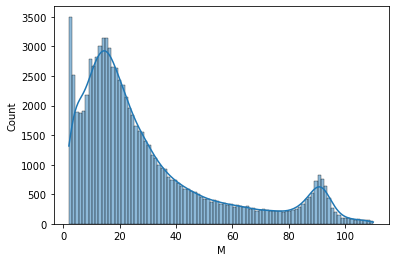

In [6]:
sns.histplot(df["M"], kde=True)

На гистограмме распределения можно наглядно заметить хвост тяжёлый хвост справа. Но при этом подобный тяжёлый хвост образуют довольно большое количество элементов и, к тому же, они образуют что-то похожее на нормальное распределение. Из этого можно сделать вывод, что подобные большие значения являются не аномалией, а скорее просто особенностью в данных, которая может даже стать полезным признаком при решении нашей задачи.

<AxesSubplot:xlabel='px1', ylabel='Count'>

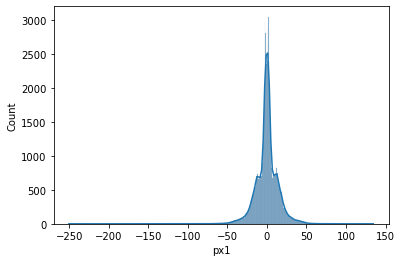

In [7]:
sns.histplot(df["px1"], kde=True)

Вообще можно заметить, что распределения большинства признаков похоже на нормальное. Это вполне логично, потому что многие физические явления можно описать нормальным распределением.

При подобных распределениях данных, где значения величин признаков могут сильно отличаться друг от друга, но при этом не являются выбросами, больше подходит не удаление признаков, а нормализация данных, потому что она помогает сохранить информацию о том, что одна величина сильно больше другой, но при этом не мешает обучению моделей, например, основанных на градиентном спуске.  
Тем не менее, были испробованы оба метода и в промежуточных решениях метод с удалением "аномалий" помог повысить точность. Но в финальном решении была применена нормализация (и то не для всех моделей, некоторые принимали нормализированные данные, некоторые - нет, т.к. это давало большую точность).

### Feature engineering

В первую очередь, стоит заметить, что половина признаков в датасете описывают первую элементарную частицу в эксперименте, когда нам нужно предсказывать заряд второй. И единственная фича, связывающая первую и вторую частицу - это их инвариантная масса. Кстати, она довольно сильно коррелирует с другими величинами, и её можно хорошо предсказывать с помощью регрессионных МЛ-моделей.
Поэтому я решил, что нам было бы неплохо попытаться найти отдельно массу первой и второй частицы.  
Я не нашёл в интернете чёткой математической формулы, позволяющей из имеющихся данных точно высчитать массу первой и второй частицы. Но, по-сути, нам не так важна точность, если мы хотим использовать её для прогнозирующих моделей. Нам, скорее, важно, чтобы она отражала некую зависимость и общую взаимную корреляцию с другими признаками.  
Поэтому я придумал следующий метод:  

Во-первых, мы знаем, что саму инвариантную массу можно предсказать с довольно высокой точностью, используя имеющиеся данные. С задачей предсказания хорошо справляются как модели классического МЛя, такие как регрессионные деревья решений, К-ближайших соседей или Градиентный бустинг, так и полносвязные нейросети (в точности они не уступают, и даже превосходят некоторые другие алгоритмы). Но для моего метода я буду использовать нейросети, т.к. там проще реализовать описанный ниже алгоритм:

1. Предположим, что первоначальная масса каждой частицы не зависит от массы частицы, с которой она столкнётся в ходе эксперимента (это довольно логично);   

2. Построим полносвязную нейронную сеть, которая на вход будет принимать {E, p(x, y, z), eta, phi, q} частицы, а на выходе предсказывать её массу;  

3. В ходе обучения нейросети, будем подавать ей на вход сперва данные для первой частицы, участвующей в эксперементе, а потом второй (главное, чтобы они были из одного эксперимента!);  

4. В качестве функции ошибки для нейросети будет использоваться (M - (m1 + m2)), где m1 - предсказания модели для первой частицы, m2 - для второй, а M - инвариантная масса обеих частиц;

5. После обучения модели будем считать массу для первой частицы, используя модель, а массу для второй как M - m1.  

In [ ]:
y = torch.FloatTensor(df["M"].values)
X1 = torch.FloatTensor(df[['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1']].values)
X2 = torch.FloatTensor(df[['E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', 'Q2']].values)

def shuffle(x1, x2, y):
    for _ in range(len(y)*3):
        i, j = random.randint(0, len(y)-1), random.randint(0, len(y)-1)
        x1[i], x1[j] = x1[j], x1[i]
        x2[i], x2[j] = x2[j], x2[i]
        y[i], y[j] = y[j], y[i]
    return x1, x2, y


X1, X2, y = shuffle(X1, X2, y)

In [495]:
p = int(len(y)*0.8)

train_dataset, valid_dataset = (X1[:p], X2[:p], y[:p]), (X1[p:], X2[p:], y[p:])

In [496]:
model = nn.Sequential(nn.Linear(8, 20),
                      nn.ReLU(),
                      nn.Linear(20, 10),
                      nn.ReLU(),
                      nn.Linear(10, 4),
                      nn.ReLU(),
                      nn.Linear(4, 1))

In [497]:
def myLoss(m1_predict, m2_predict, total_m):
    return (total_m - (m1_predict + m2_predict)).abs().sum() * (1/len(m1_predict))

Используется оптимизатор Adam, т.к. он показал более высокую сходимость, чем SGD. Также юзается маленький learning rate + большое количество эпох, потому что было проведено исследование и выяснилось, что так модель хоть и сходится значительно дольше, но показывает более высокую точность.

In [498]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = myLoss

EPOCHS = 250
BATCH_SIZE = 1024

In [468]:
# можно не обучать самостоятельно, уже обученная модель импортируется ниже

for e in range(EPOCHS):
    model.train()
    train_loss = []
    for i in range(0, len(train_dataset[0]), BATCH_SIZE):
        step = min(len(train_dataset[0]), i+BATCH_SIZE)
        x1, x2, y = train_dataset[0][i:step], train_dataset[1][i:step], train_dataset[2][i:step]
        optimizer.zero_grad()
        o1, o2 = model(x1), model(x2)
        loss = criterion(o1, o2, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()/BATCH_SIZE)
    model.eval()
    valid_loss = []
    for i in range(len(valid_dataset[0])):
        x1, x2, y = valid_dataset[0][i], valid_dataset[1][i], valid_dataset[2][i]
        o1, o2 = model(x1), model(x2)
        loss = criterion(o1, o2, y)
        valid_loss.append(loss.item())
    print(f"epoch {e+1} | train loss: {np.array(train_loss).mean()} | valid loss: {np.array(valid_loss).mean()}")

epoch 1 | train loss: 29.30383795273455 | valid loss: 29.18927586392431
epoch 2 | train loss: 29.012825218937063 | valid loss: 28.766313969555043
epoch 3 | train loss: 28.402615382701537 | valid loss: 27.92302808878879
epoch 4 | train loss: 27.31265552436249 | valid loss: 26.513051714391516
epoch 5 | train loss: 25.914523308790184 | valid loss: 24.910410879843408
epoch 6 | train loss: 24.45567812346205 | valid loss: 23.064435283808308
epoch 7 | train loss: 23.04919303670714 | valid loss: 21.229367285526916
epoch 8 | train loss: 21.972986254511 | valid loss: 19.70104769902658
epoch 9 | train loss: 21.291970061350472 | valid loss: 18.634746298258808
epoch 10 | train loss: 20.93018175906773 | valid loss: 17.96240274265937
epoch 11 | train loss: 20.76128158690054 | valid loss: 17.560592120541937
epoch 12 | train loss: 20.6833959840521 | valid loss: 17.326775203934485
epoch 13 | train loss: 20.639580580252634 | valid loss: 17.18278265335846
epoch 14 | train loss: 20.605324486388437 | valid 

epoch 112 | train loss: 17.92689517932602 | valid loss: 17.915375668299912
epoch 113 | train loss: 17.926438657543326 | valid loss: 17.91644825749478
epoch 114 | train loss: 17.92599342593664 | valid loss: 17.917427792024405
epoch 115 | train loss: 17.925553755669654 | valid loss: 17.918538381392036
epoch 116 | train loss: 17.92512566153007 | valid loss: 17.9196452224946
epoch 117 | train loss: 17.924704498882534 | valid loss: 17.920719318726825
epoch 118 | train loss: 17.92429012663757 | valid loss: 17.92169176376672
epoch 119 | train loss: 17.923881964592994 | valid loss: 17.922538674761213
epoch 120 | train loss: 17.92347670733174 | valid loss: 17.923282791757728
epoch 121 | train loss: 17.923081124130682 | valid loss: 17.92402415177023
epoch 122 | train loss: 17.922692028782034 | valid loss: 17.924816337665245
epoch 123 | train loss: 17.922313482701025 | valid loss: 17.92569781325693
epoch 124 | train loss: 17.92194363135326 | valid loss: 17.926712477486966
epoch 125 | train loss: 

KeyboardInterrupt: 

In [13]:
mass_prediction = torch.load("mass_prediction_model.pt")

Также добавим вполне стандартных физических признаков для нашей задачи: разница между энергиями, вектор импульса, кинетическая энергия, ускорение и т.д.

In [14]:
def feature_engineering(df):
    m1 = mass_prediction(torch.FloatTensor(df[['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', 'Q1']].values)).detach().numpy().flatten()
    m2 = df["M"] - m1
    df["M1"] = m1
    df["M2"] = m2
    df['pz_diff'] = df.pz1 - df.pz2
    df['pt1^2'] = df.pt1**2
    df['pt2^2'] = df.pt2**2
    df['eta_diff'] = df.eta1 - df.eta2
    df["Total_E"] = df.E1 + df.E2
    df["MomentumVector_E1"] = df.px1 + df.py1 +df.pz1
    df["MomentumVector_E2"] = df.px2 + df.py2 + df.pz2
    df["KineticEnergy_E1"] = (df.px1*df.px1) + (df.py1*df.py1) + (df.pz1*df.pz1)
    df["KineticEnergy_E2"] = (df.px2*df.px2) + (df.py2*df.py2) + (df.pz2*df.pz2)
    df["TotalMomentumVector"] = (df.px1 + df.px2) + (df.py1 + df.py2) + (df.pz1 + df.pz2)
    df["TotalKineticEnergy"] = (df.px1*df.px1) + (df.py1*df.py1) + (df.pz1*df.pz1) + (df.px2*df.px2) + (df.py2*df.py2) + (df.pz2*df.pz2)
    df["EnergyMomentum_E1"] = df.E1/df.pt1
    df["EnergyMomentum_E2"] = df.E2/df.pt2
    df["TotalTransverseMomentum"] = df.pt1 + df.pt2
    df["TotalPseudorapidity"] = df.eta1 + df.eta2
    return df

In [15]:
df = feature_engineering(df)

In [16]:
df.head()

,E1,px1,py1,pz1,pt1,eta1,phi1,Q1,E2,px2,py2,pz2,pt2,eta2,phi2,M,Q2,M1,M2,pz_diff,pt1^2,pt2^2,eta_diff,Total_E,MomentumVector_E1,MomentumVector_E2,KineticEnergy_E1,KineticEnergy_E2,TotalMomentumVector,TotalKineticEnergy,EnergyMomentum_E1,EnergyMomentum_E2,TotalTransverseMomentum,TotalPseudorapidity
0,24.08500,-4.591070,20.110600,12.43260,20.62800,0.571144,1.795240,-1,2.57188,-2.15672,-1.30836,0.501343,2.52255,0.197459,-2.59630,12.0101,1,10.439666,1.570434,11.931257,425.514384,6.363259,0.373685,26.65688,27.952130,-2.963737,580.083699,6.614592,24.988393,586.698291,1.167588,1.019556,23.15055,0.768603
1,22.94630,-4.677580,5.187980,-21.85720,6.98534,-1.858470,2.304500,1,67.16120,-8.24769,11.37090,-65.675800,14.04710,-2.246710,2.19832,4.0102,1,11.212400,-7.202200,43.818600,48.794975,197.321018,0.388240,90.10750,-21.346800,-62.552590,526.532083,4510.632463,-83.899390,5037.164546,3.284922,4.781143,21.03244,-4.105180
2,2.39342,0.346488,-1.935140,1.36514,1.96592,0.648077,-1.393620,1,33.86190,-30.87370,-8.12102,11.291100,31.92390,0.346700,-2.88438,11.0103,1,10.755643,0.254657,-9.925960,3.864841,1019.135391,0.301377,36.25532,-0.223512,-27.703620,5.728428,1146.625257,-27.927132,1152.353685,1.217455,1.060707,33.88982,0.994777
3,80.32260,-14.435900,26.110100,74.57610,29.83510,1.647090,2.075850,1,22.38180,2.30876,7.14518,21.084600,7.50892,1.755900,1.25826,12.0104,-1,10.895534,1.114866,53.491500,890.133192,56.383880,-0.108810,102.70440,86.250300,30.538540,6451.727222,500.944327,116.788840,6952.671549,2.692218,2.980695,37.34402,3.402990
4,3.20864,2.846250,-0.351847,-1.43891,2.86791,-0.482756,-0.122994,1,27.96590,-4.05881,-9.86542,-25.851300,10.66770,-1.618370,-1.96111,11.0105,1,9.692578,1.317922,24.412390,8.224908,113.799823,1.135614,31.17454,1.055493,-39.775530,10.295397,782.090162,-38.720037,792.385559,1.118808,2.621549,13.53561,-2.101126


Попробуем использовать алгоритм снижения размерности Umap, чтобы визуализировать распределение данных и посмотреть, образуют ли они какие-то кластеры, которые могут стать важным признаком для нашей задачи. Я посчитал, что для этой задачи будет лучше интерпретировать данные о обеих частицах из эксперимента по-отдельности (это действительно показало лучшие результаты, чем если брать их вместе).

In [10]:
df_q1 = df[['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', "M1", 'MomentumVector_E1', "KineticEnergy_E1", "EnergyMomentum_E1"]]
df_q2 = df[['E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', "M2", 'MomentumVector_E2', "KineticEnergy_E2", "EnergyMomentum_E2"]]
df_q1.rename(columns={n: n.replace("1", "") for n in df_q1.columns}, inplace=True)
df_q2.rename(columns={n: n.replace("2", "") for n in df_q2.columns}, inplace=True)

df_every_q = pd.concat([df_q1, df_q2], axis=0)

C:\Users\DjGle\AppData\Local\Temp\ipykernel_7488\2508672455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1.rename(columns={n: n.replace("1", "") for n in df_q1.columns}, inplace=True)
C:\Users\DjGle\AppData\Local\Temp\ipykernel_7488\2508672455.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q2.rename(columns={n: n.replace("2", "") for n in df_q2.columns}, inplace=True)


In [ ]:
# обучение модели занимает оооочень много времени, поэтому можно импортировать уже обученную мной

umap_model = umap.UMAP(n_neighbors=20)
embedding = umap_model.fit_transform(df_every_q)

Также попробуем кластеризировать данные с помощью к-средних (10 кластеров показали себя наиболее хорошо)

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(embedding)

In [19]:
umap_model = pickle.load(open("umap_clusterizator.pkl", "rb"))
kmeans = pickle.load(open("kmeans_clusterizator.pkl", "rb"))

In [11]:
embedding = umap_model.transform(df_every_q)
labels = kmeans.predict(embedding)

Визуализируем кластеризованные нами данные (при самостоятельном обучении, график распределения может быть другим, т.к. в umap есть некоторая доля рандомности, но тем не менее, общий тренд будет схож)

In [12]:
colors = ["r", "g", "b", "yellow", "pink", "orange", "c", "m", 'aquamarine', 'mediumseagreen']
labels_color = [colors[l] for l in labels]

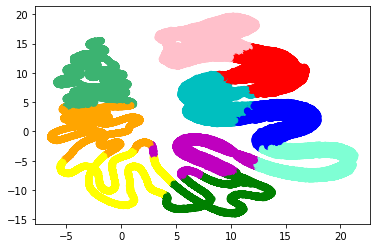

In [13]:
plt.scatter(embedding[:, 0], embedding[:, 1], color=labels_color)

Результат просто невероятен! График получился очень интересным и красивым. В данных определённо скрыта какая-то красивая закономерность, если при снижении их размерности мы можем наблюдать такое. 

Создадим 4 дополнительных признака: эмбеддинги для каждой частицы и к какому кластеру относится каждая частица.

In [14]:
cluster_embedds_q1 = embedding[:len(embedding)//2]
cluster_group_q1 = labels[:len(embedding)//2]
cluster_embedds_q2 = embedding[len(embedding)//2:]
cluster_group_q2 = labels[len(embedding)//2:]

In [15]:
df["cluster_embedds_q1"] = cluster_embedds_q1.tolist()
df["cluster_group_q1"] = cluster_group_q1
df["cluster_embedds_q2"] = cluster_embedds_q2.tolist()
df["cluster_group_q2"] = cluster_group_q2

В подобных задачах часто помогает генерирование эмбеддингов с помощью нейронных сетей, т.к. бОльшая часть наших признакми некатегориальные, а числовые, и нейронная сеть может вывести корреляции, которые не сможет обнаружить модель, основанная, например, на деревьях решений (т.к. нейронная сеть может по-другому трансформировать пространство признаков). Поэтому мы можем обучить нейронную сеть для задачи классификации целевой переменной, и хоть она будет показывать невысокую точность, мы можем убрать у неё последний слой, и использовать для генерации эмбеддингов, с которыми умеют работать некоторые модели, по-типу CatBoosting'а.

In [16]:
X = torch.FloatTensor(df[set(df.columns) - set(["Q2", "cluster_embedds_q1", "cluster_embedds_q2"])].values)
y = torch.LongTensor((df["Q2"]>0).astype(int).values) #1 => 1, -1 => 0

C:\Users\DjGle\AppData\Local\Temp\ipykernel_7488\2346949502.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = torch.FloatTensor(df[set(df.columns) - set(["Q2", "cluster_embedds_q1", "cluster_embedds_q2"])].values)


In [510]:
model = nn.Sequential(nn.Linear(35, 128),
                      nn.Dropout(0.25),
                      nn.ReLU(),
                      nn.Linear(128, 2),
                      nn.Sigmoid())

In [511]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

EPOCHS = 50
BATCH_SIZE = 512

In [512]:
for e in range(EPOCHS):
    model.train()
    for i in range(0, len(train_dataset[0]), BATCH_SIZE):
        step = min(len(train_dataset[0]), i+BATCH_SIZE)
        x, l = X[i:step], y[i:step]
        optimizer.zero_grad()
        loss = criterion(model(x), l)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item()/BATCH_SIZE)

In [24]:
model = torch.load("embedding_generator.pt")

In [17]:
df["embeddings"] = model[0](X).sigmoid().tolist()

#### Выбор и обучение моделей

На выбор и обучение моделей ушла бОльшая часть времени. Были опробованы почти все классические модели машинного обучения для задач классификации (нейронки совсем печально работали, как полносвязки, так рекурренты).  
И в ходе валидации моделей было замечено одно крайне важное наблюдение: разные модели выдают правильные предикты на разных сэмплах валидационной выборки, хоть их суммарная точность и оставалась примерно одинаковой. Поэтому я решил попытаться обучить те модели, у которых объединение множеств правильных ответов будет максимальным. А затем подобрать алгоритм, который на основании вероятностных предсказаний каждой модели будет выносить общий предикт, к какому классу относится сэмпл.

В свой своеобразный ансамбль моделей я включил следующие:  

1. CatBoost - во-первых, потому что он единственный умел работать с фичами эмбеддингами;
2. Random Forest - общая точность чуть ниже, чем у catboost'а, но на некоторых сэмплах, на которых catboost работал плохо, он выдавал правильные предикты. Предположительно, потому что юзал другие фичи;
3. К-ближайших;
4. LGBM;
5. Логистическая регрессия.  

Пробовал просто деревья решений, метод опорных векторов, разные более классические методы градиентного бустинга. Но в купе с остальными алгоритмами "площадь покрытия" правильных ответов была меньше.  

Для используемых в ансамбле моделей были тчательно подобраны гипперпараметры. Ещё стоит отметить, что разным моделям на вход подавались разные фичи, с которыми они показывали бОльшую точность. А также для разных моделей данные по-разному предобрабатывались, как было написано ещё в пункте с анализом и выбором выбросов. Например, для того-же SVC данные нормализировались перед обучением (хоть он и не вошёл в конечном итоге в ансамбль).  

Модели обучались на разных частях выборки, а для оценки точности первоначально использовалась кросс-валидация.

In [20]:
def models_training(model_idx, train, val):
    if model_idx == 1:
        print("Training CatBoost")
        clf = CatBoostClassifier(iterations=1000, learning_rate=0.05)
        train_pool = Pool(train.drop("Q2", axis=1), train["Q2"], cat_features=["cluster_group_q1", "cluster_group_q2"],
                                    embedding_features=["cluster_embedds_q1", "cluster_embedds_q2", "embeddings"])
        valid_pool = Pool(val.drop("Q2", axis=1), val["Q2"], cat_features=["cluster_group_q1", "cluster_group_q2"],
                                    embedding_features=["cluster_embedds_q1", "cluster_embedds_q2", "embeddings"])
        clf.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50, verbose=50)
        return clf, clf.predict_proba(valid_pool)[:, 1], clf.predict_proba(train_pool)[:, 1]
    if model_idx == 2:
        print("Training Random Forest")
        X_train, y_train = train.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), train["Q2"]
        X_valid, y_valid = val.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), val["Q2"]
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        return clf, clf.predict_proba(X_valid)[:, 1], clf.predict_proba(X_train)[:, 1]
    if model_idx == 3:
        print("Training KNN")
        X_train, y_train = train.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), train["Q2"]
        X_valid, y_valid = val.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), val["Q2"]
        clf = KNeighborsClassifier(n_neighbors=5)
        clf.fit(X_train, y_train)
        return clf, clf.predict_proba(X_valid)[:, 1], clf.predict_proba(X_train)[:, 1]
    if model_idx == 4:
        print("Training LGBM")
        X_train, y_train = train.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), train["Q2"]
        X_valid, y_valid = val.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), val["Q2"]
        clf = lgb.LGBMClassifier(objective="binary", metric="auc", learning_rate=0.05, max_depth=5, num_leaves=64, n_estimators=2000)
        clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=50)
        return clf, clf.predict_proba(X_valid)[:, 1], clf.predict_proba(X_train)[:, 1]
    if model_idx == 5:
        print("Training Logistic regression")
        X_train, y_train = train.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), train["Q2"]
        X_valid, y_valid = val.drop(["Q2", "cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1), val["Q2"]
        clf = LogisticRegression(random_state=0).fit(X_train, y_train)
        return clf, clf.predict_proba(X_valid)[:, 1], clf.predict_proba(X_train)[:, 1]

In [21]:
targets = df["Q2"].values
train_data_target = df
feature_cols = list(train_data_target.columns).remove("Q2")

cv = KFold(n_splits=5, random_state=100, shuffle=True)
oof = np.zeros(len(train_data_target))
train_preds = np.zeros(len(train_data_target))

models = []


for fold_, (train_idx, val_idx) in enumerate(cv.split(train_data_target, targets), 1):
    train, val = train_data_target.iloc[train_idx], train_data_target.iloc[val_idx]
    clf, valid_predicts, train_predicts = models_training(fold_, train, val)
    oof[val_idx] = valid_predicts
    train_preds[train_idx] += train_predicts / (cv.n_splits-1)
    models.append(clf)
    print(f"Training with fold {fold_} completed")

Training CatBoost
0:	learn: 0.6878866	test: 0.6878503	best: 0.6878503 (0)	total: 268ms	remaining: 4m 27s
50:	learn: 0.6417598	test: 0.6427586	best: 0.6427586 (50)	total: 4.14s	remaining: 1m 16s
100:	learn: 0.6387827	test: 0.6417503	best: 0.6417043 (93)	total: 7.88s	remaining: 1m 10s
150:	learn: 0.6365102	test: 0.6412828	best: 0.6412600 (141)	total: 11.8s	remaining: 1m 6s
200:	learn: 0.6345980	test: 0.6412277	best: 0.6411584 (184)	total: 15.8s	remaining: 1m 2s
250:	learn: 0.6324973	test: 0.6411618	best: 0.6411123 (226)	total: 19.6s	remaining: 58.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6411123487
bestIteration = 226

Shrink model to first 227 iterations.
Training with fold 1 completed
Training Random Forest
Training with fold 2 completed
Training KNN
Training with fold 3 completed
Training LGBM


C:\Users\DjGle\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\DjGle\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[50]	valid_0's auc: 0.630498
Training with fold 4 completed
Training Logistic regression
Training with fold 5 completed


C:\Users\DjGle\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
models = [pickle.load(open(f"classifiers_ensemble//{model}.pkl", "rb")) for model in ["catboost", 
                                                                                      "random_forest",
                                                                                      "knn",
                                                                                      "lgb",
                                                                                      "lreg"]]

In [32]:
ensember_booster = pickle.load(open("model_ensembler.pkl", "rb"))

Оценим точность работы нашей модели. Конечно, оценка будет не совсем корректной, т.к. мы валидируем на том же, на чём и обучали. Но точность на тестовой выборке отдельно мы можем всегда оценить, отправив сабмит на каггл :)

In [7]:
eval_targets = df["Q2"].values
df.drop('Q2', axis=1, inplace=True)
pool_for_eval = Pool(df, cat_features=["cluster_group_q1", "cluster_group_q2"],
                                    embedding_features=["cluster_embedds_q1", "cluster_embedds_q2", "embeddings"])
df_for_eval = df.drop(["cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1)

In [41]:
total_probs = []
for i in range(len(models)):
    if i == 0:
        predicts = models[i].predict_proba(pool_for_eval)[:, 1]
    else:
        predicts = models[i].predict_proba(df_for_eval)[:, 1]
    total_probs.append(predicts)

In [42]:
total_probs = np.array(total_probs).transpose((1, 0))

In [43]:
predicts = ensember_booster.predict(total_probs)

In [44]:
(predicts == eval_targets).mean()

0.9474651121709945

В принципе, явного переобучения нет, точность модели не 99-100%.

#### Осуществим предсказания для тестовой выборки

In [25]:
test_df = feature_engineering(test_df)
test_df["M"] = test_df["M"].fillna(test_df["M"].mean())
test_df["M2"] = test_df["M2"].fillna(test_df["M2"].mean())

df_q1 = test_df[['E1', 'px1', 'py1', 'pz1', 'pt1', 'eta1', 'phi1', "M1", 'MomentumVector_E1', "KineticEnergy_E1", "EnergyMomentum_E1"]]
df_q2 = test_df[['E2', 'px2', 'py2', 'pz2', 'pt2', 'eta2', 'phi2', "M2", 'MomentumVector_E2', "KineticEnergy_E2", "EnergyMomentum_E2"]]
df_q1.rename(columns={n: n.replace("1", "") for n in df_q1.columns}, inplace=True)
df_q2.rename(columns={n: n.replace("2", "") for n in df_q2.columns}, inplace=True)

df_every_q = pd.concat([df_q1, df_q2], axis=0)
embedding = umap_model.transform(df_every_q)
labels = kmeans.predict(embedding)

cluster_embedds_q1 = embedding[:len(embedding)//2]
cluster_group_q1 = labels[:len(embedding)//2]
cluster_embedds_q2 = embedding[len(embedding)//2:]
cluster_group_q2 = labels[len(embedding)//2:]

test_df["cluster_embedds_q1"] = cluster_embedds_q1.tolist()
test_df["cluster_group_q1"] = cluster_group_q1
test_df["cluster_embedds_q2"] = cluster_embedds_q2.tolist()
test_df["cluster_group_q2"] = cluster_group_q2

X = torch.FloatTensor(test_df[set(test_df.columns) - set(["Q2", "cluster_embedds_q1", "cluster_embedds_q2"])].values)
test_df["embeddings"] = model[0](X).sigmoid().tolist()

C:\Users\DjGle\AppData\Local\Temp\ipykernel_22096\2963318818.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q1.rename(columns={n: n.replace("1", "") for n in df_q1.columns}, inplace=True)
C:\Users\DjGle\AppData\Local\Temp\ipykernel_22096\2963318818.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_q2.rename(columns={n: n.replace("2", "") for n in df_q2.columns}, inplace=True)
C:\Users\DjGle\AppData\Local\Temp\ipykernel_22096\2963318818.py:24: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X = torch.FloatTensor(test_df[set(test_df.columns) 

In [26]:
test_pool = Pool(test_df, cat_features=["cluster_group_q1", "cluster_group_q2"],
                                    embedding_features=["cluster_embedds_q1", "cluster_embedds_q2", "embeddings"])
test_df = test_df.drop(["cluster_embedds_q1", "cluster_embedds_q2", "embeddings"], axis=1)

In [27]:
total_probs = []
for i in range(len(models)):
    if i == 0:
        predicts = models[i].predict_proba(test_pool)[:, 1]
    else:
        predicts = models[i].predict_proba(test_df)[:, 1]
    total_probs.append(predicts)

In [28]:
total_probs = np.array(total_probs).transpose((1, 0))

In [29]:
predicts = ensember_booster.predict(total_probs)

In [31]:
sub = pd.DataFrame({"Event": events, "Q2": predicts})
sub.to_csv("sub10_ensemble_plus_knn.csv", index=False)